In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        # transforms.RandomRotation(degrees=45)
    ])

train_dataset = CIFAR10(root='data/', train=True, download=True, transform=data_transform)
test_dataset = CIFAR10(root='data/', train=False, download=False, transform=data_transform)
# torch.utils.data.random_split(dataset, lengths)

len(train_dataset), len(test_dataset)

100%|██████████| 170498071/170498071 [00:06<00:00, 25541661.14it/s]


Extracting data/cifar-10-python.tar.gz to data/


(50000, 10000)

# `VISUALIZING DATASET`

In [4]:
idx_to_class = {idx:cls for cls, idx in train_dataset.class_to_idx.items()}

def imshw(ax,subplotsCount, x, y):
    ax.imshow(x)
    yc = -(0.1 + 0.01*subplotsCount)
    ax.set_title(idx_to_class[y], fontsize = 8,y=yc)
    ax.axis('off')

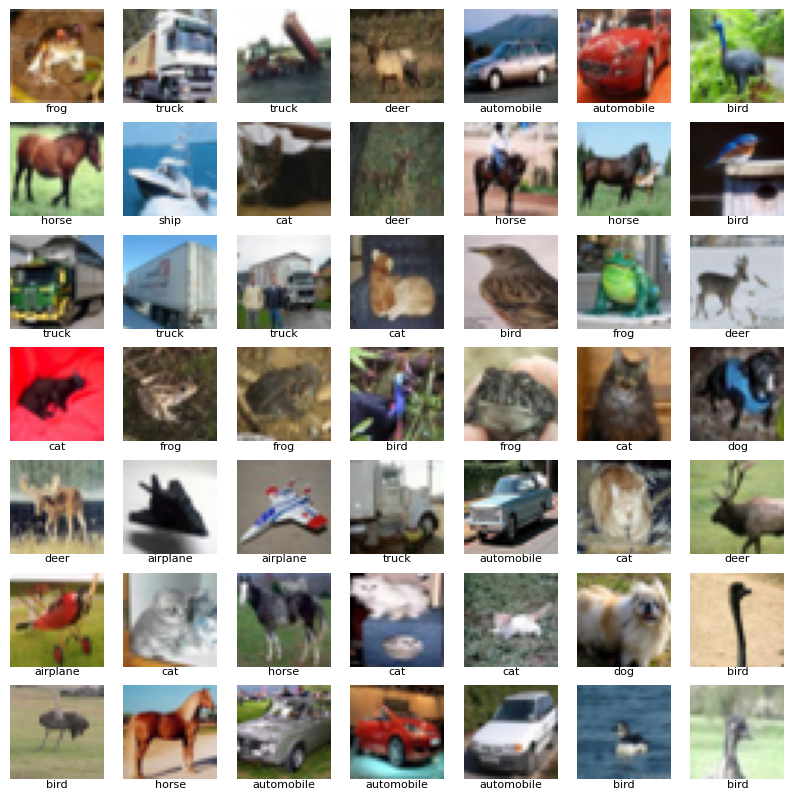

In [5]:
subs = 7
fg, axs = plt.subplots(subs, subs, figsize=(10,10))
axs = axs.ravel()
for ax, (x, y) in zip(axs, train_dataset):
    x = x.permute(1,2,0).numpy()
    imshw(ax, subs, x, y)

# `MODELS TRAINING && Evaluation`

In [6]:
batch_size = 64
epochs = 40
image_shape = (3,32,32)
lr = 0.0001
classes = len(idx_to_class)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
## Helper
@torch.no_grad()
def loss_acc_loader(model, data_loader, device):
    model.eval()

    total_predicts = []
    total_targets = []
    total_loss = 0
    for data, targets in data_loader:
        data = data.to(device)
        targets = targets.to(device)

        logits = model(data)
        total_loss += loss_fn(logits, targets).item()

        total_predicts.append(logits.argmax(1))
        total_targets.append(targets)

    total_predicts = torch.concat(total_predicts)
    total_targets = torch.concat(total_targets)

    avg_loss = total_loss / len(data_loader)
    accuracy = (total_predicts == total_targets).float().mean().item()

    return avg_loss, accuracy, total_predicts, total_targets


def get_parameters_info(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
    nontrainable = sum(p.numel() for p in model.parameters() if p.requires_grad==False)

    return trainable, nontrainable

## my CNN

In [8]:
class myCNN(nn.Module):
    def __init__(self, input_channels, classes) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(3,3), padding='valid', bias=False),
                                    nn.BatchNorm2d(num_features=64),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding='valid', bias=False),
                                    nn.BatchNorm2d(num_features=64),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.MaxPool2d((2,2)),
                                    nn.Dropout2d(0.4))

        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='valid', bias=False),
                                    nn.BatchNorm2d(num_features=128),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding='valid', bias=False),
                                    nn.BatchNorm2d(num_features=128),
                                    nn.ReLU())
        self.layer6 = nn.Sequential(nn.MaxPool2d((2,2)),
                                    nn.Dropout2d(0.4))
        self.flat = nn.Flatten()

        self.fc1 = nn.Sequential(nn.Linear(3200, 512),
                                 nn.ReLU(),
                                 nn.Dropout1d(0.5))

        self.fc2 = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU())

        self.fc3 = nn.Linear(256, classes)

    def forward(self, x):
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        layer5 = self.layer5(layer4)
        layer6 = self.layer6(layer5)
        flat = self.flat(layer6)
        fc1 = self.fc1(flat)
        fc2 = self.fc2(fc1)
        fc3 = self.fc3(fc2)
        return fc3


In [9]:
modelmy = myCNN(image_shape[0], classes).to(device)

tr, nontr = get_parameters_info(modelmy)
print(f"Total trainable parameters= {tr}\nTotal non-trainable parameters= {nontr}")

loss_fn = nn.CrossEntropyLoss()
optim_my = torch.optim.Adam(modelmy.parameters(), lr)

Total trainable parameters= 2033354
Total non-trainable parameters= 0


### TrainingLoop

In [10]:
total_batches = len(train_loader)
losses = []
for epoch in range(epochs):
    modelmy.train()  # Set the model to training mode

    print(f'Epoch {epoch+1}/{epochs}', end=' ')
    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device)
        targets = targets.to(device)

        logits = modelmy(data)
        loss = loss_fn(logits, targets)

        optim_my.zero_grad()
        loss.backward()
        optim_my.step()

    # Running model on the entire dataset after each epoch
    train_loss, accuracy, _, _ = loss_acc_loader(modelmy, train_loader, device)

    losses.append(train_loss)
    print(f'Loss: {train_loss:.4f}, Accuracy: {accuracy*100:.2f}%')


Epoch 1/40 Loss: 1.5863, Accuracy: 49.21%
Epoch 2/40 Loss: 1.4646, Accuracy: 53.00%
Epoch 3/40 Loss: 1.3736, Accuracy: 58.20%
Epoch 4/40 Loss: 1.2592, Accuracy: 62.70%
Epoch 5/40 Loss: 1.2101, Accuracy: 62.35%
Epoch 6/40 Loss: 1.1505, Accuracy: 66.78%
Epoch 7/40 Loss: 1.0887, Accuracy: 69.07%
Epoch 8/40 Loss: 1.0334, Accuracy: 69.64%
Epoch 9/40 Loss: 0.9824, Accuracy: 72.50%
Epoch 10/40 Loss: 0.9659, Accuracy: 74.05%
Epoch 11/40 Loss: 0.9418, Accuracy: 74.34%
Epoch 12/40 Loss: 0.8869, Accuracy: 76.12%
Epoch 13/40 Loss: 0.8954, Accuracy: 75.73%
Epoch 14/40 Loss: 0.8504, Accuracy: 77.08%
Epoch 15/40 Loss: 0.8364, Accuracy: 78.42%
Epoch 16/40 Loss: 0.8117, Accuracy: 77.87%
Epoch 17/40 Loss: 0.8160, Accuracy: 78.70%
Epoch 18/40 Loss: 0.7910, Accuracy: 80.50%
Epoch 19/40 Loss: 0.7779, Accuracy: 80.77%
Epoch 20/40 Loss: 0.7586, Accuracy: 81.52%
Epoch 21/40 Loss: 0.7306, Accuracy: 80.61%
Epoch 22/40 Loss: 0.7249, Accuracy: 82.26%
Epoch 23/40 Loss: 0.7058, Accuracy: 82.48%
Epoch 24/40 Loss: 0.

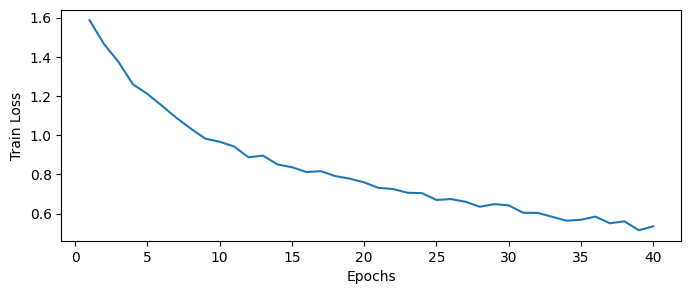

In [11]:
plt.figure(figsize=(8, 3))
plt.plot([ep+1 for ep in range(len(losses))], losses)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

### Evaluation

Loss: 0.6600, Accuracy: 80.69%


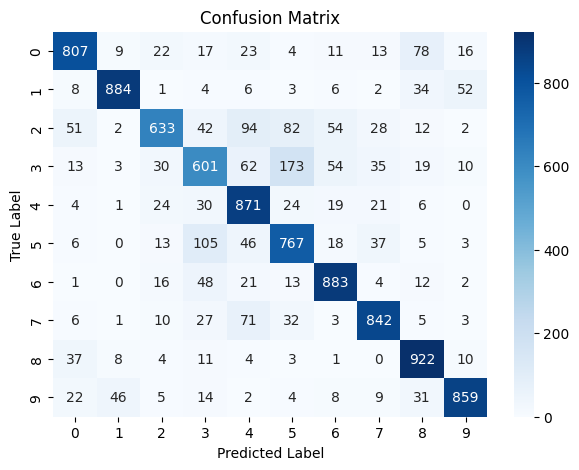

In [12]:
test_loss, accuracy, total_predicts, total_targets = loss_acc_loader(modelmy, test_loader, device)

print(f'Loss: {test_loss:.4f}, Accuracy: {accuracy*100:.2f}%')

# Compute the confusion matrix
conf_matrix = confusion_matrix(total_targets.cpu(), total_predicts.cpu())

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Model Save

In [13]:
model_states = {'model_state': modelmy.state_dict(),
                'optim_state': optim_my.state_dict(),
                'input_shape': (3,32,32),
                'labels_encoder': train_dataset.class_to_idx,
                'min_max_norm': True,
                'mean_std_norm': False,
                'batch_size': batch_size,
                'epochs': epochs,
                'loss_tr': train_loss,
                'loss_ts': test_loss}
torch.save(model_states, '/kaggle/working/myCNN_states.pt')

# Save Entire Model
torch.save(modelmy, f'/kaggle/working/myCNN.bin')

# states_dict = torch.load('/kaggle/working/myCNN_states.pt', weights_only=True)
# loaded_modelmy = myCNN(image_shape, 10)
# loaded_modelmy.load_state_dict(states_dict['model_state'])
# loaded_optim = torch.optim.Adam(modelmy.parameters())
# loaded_optim.load_state_dict(states_dict['optim_state'])


## RESNET-50

In [14]:
from torchvision.models import resnet50, ResNet50_Weights
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class Resnet_base(nn.Module):
    def __init__(self, input_size, classes, trainable=False):
        super(Resnet_base, self).__init__()
        
        self.res50_model = resnet50(weights=ResNet50_Weights(ResNet50_Weights.IMAGENET1K_V2))
        for p in self.res50_model.parameters(): p.requires_grad=trainable
        
        self.res50_model.avgpool = Identity()
        self.res50_model.fc = nn.Sequential(nn.Linear(2048, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, classes))
    def forward(self, x):
        x = self.res50_model(x)
        return x

In [15]:
resnet50_base = Resnet_base(1,10).to(device)

tr, nontr = get_parameters_info(resnet50_base)
print(f"Total trainable parameters= {tr}\nTotal non-trainable parameters= {nontr}")

# loss_fn = nn.CrossEntropyLoss()
optim_res = torch.optim.Adam(resnet50_base.parameters(), lr)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


Total trainable parameters= 1054218
Total non-trainable parameters= 23508032


### TrainingLoop

In [16]:
total_batches = len(train_loader)
losses = []
for epoch in range(epochs):
    resnet50_base.train()  # Set the model to training mode

    print(f'Epoch {epoch+1}/{epochs}', end=' ')
    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device)
        targets = targets.to(device)

        logits = resnet50_base(data)
        loss = loss_fn(logits, targets)

        optim_res.zero_grad()
        loss.backward()
        optim_res.step()

    # Running model on the entire dataset after each epoch
    train_loss, accuracy, _, _ = loss_acc_loader(resnet50_base, train_loader, device)

    losses.append(train_loss)
    print(f'Loss: {train_loss:.4f}, Accuracy: {accuracy*100:.2f}%')

Epoch 1/40 Loss: 1.7783, Accuracy: 45.26%
Epoch 2/40 Loss: 1.8320, Accuracy: 47.68%
Epoch 3/40 Loss: 1.5670, Accuracy: 48.36%
Epoch 4/40 Loss: 1.5135, Accuracy: 49.69%
Epoch 5/40 Loss: 1.5508, Accuracy: 50.26%
Epoch 6/40 Loss: 1.4692, Accuracy: 51.11%
Epoch 7/40 Loss: 1.4556, Accuracy: 51.72%
Epoch 8/40 Loss: 1.5226, Accuracy: 51.60%
Epoch 9/40 Loss: 1.4787, Accuracy: 51.34%
Epoch 10/40 Loss: 1.5644, Accuracy: 51.73%
Epoch 11/40 Loss: 1.4440, Accuracy: 52.23%
Epoch 12/40 Loss: 1.4185, Accuracy: 53.08%
Epoch 13/40 Loss: 1.4153, Accuracy: 53.69%
Epoch 14/40 Loss: 1.3754, Accuracy: 54.32%
Epoch 15/40 Loss: 1.3363, Accuracy: 54.65%
Epoch 16/40 Loss: 1.3728, Accuracy: 54.59%
Epoch 17/40 Loss: 1.3842, Accuracy: 54.93%
Epoch 18/40 Loss: 1.3528, Accuracy: 55.14%
Epoch 19/40 Loss: 1.2740, Accuracy: 56.89%
Epoch 20/40 Loss: 1.2986, Accuracy: 55.79%
Epoch 21/40 Loss: 1.3006, Accuracy: 56.79%
Epoch 22/40 Loss: 1.3300, Accuracy: 56.80%
Epoch 23/40 Loss: 1.3975, Accuracy: 57.46%
Epoch 24/40 Loss: 1.

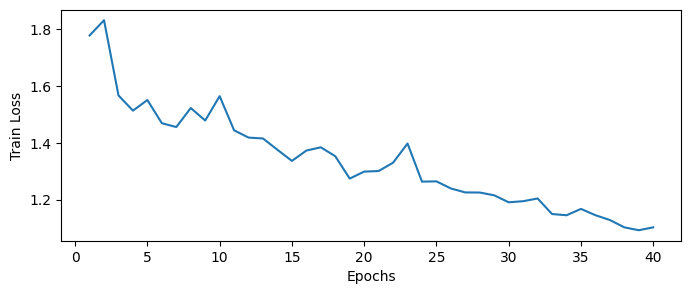

In [17]:
plt.figure(figsize=(8, 3))
plt.plot([ep+1 for ep in range(len(losses))], losses)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

### Evaluation

Loss: 1.4675, Accuracy: 50.66%


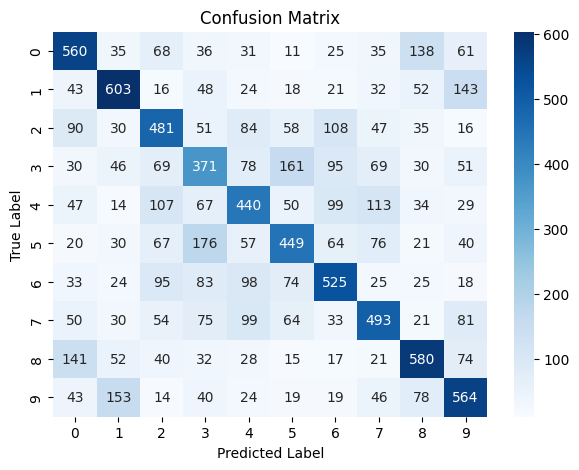

In [18]:
test_loss, accuracy, total_predicts, total_targets = loss_acc_loader(resnet50_base, test_loader, device)

print(f'Loss: {test_loss:.4f}, Accuracy: {accuracy*100:.2f}%')

# Compute the confusion matrix
conf_matrix = confusion_matrix(total_targets.cpu(), total_predicts.cpu())

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Model saving

In [19]:
model_states = {'model_state': resnet50_base.state_dict(),
                'optim_state': optim_res.state_dict(),
                'input_shape': (3,32,32),
                'labels_encoder': train_dataset.class_to_idx,
                'min_max_norm': True,
                'mean_std_norm': False,
                'batch_size': batch_size,
                'epochs': epochs,
                'loss_tr': train_loss,
                'loss_ts': test_loss}
torch.save(model_states, '/kaggle/working/resnet50_base_states.pt')


## Save Entire Model
torch.save(resnet50_base, '/kaggle/working/resnet50_base.bin')